<a href="https://colab.research.google.com/github/aaronseq12/HeartDiseasesPrediction/blob/main/Enhanced2025_Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import shap

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'class']
data = pd.read_csv(url, names=names, na_values='?')

In [3]:
# Preprocessing
# Separate features and target
X = data.drop('class', axis=1)
y = data['class']

In [4]:
# Binarize the target variable
y_binary = y.copy()
y_binary[y_binary > 0] = 1

In [5]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [6]:
# Create preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [7]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [10]:
# Split the data
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary = train_test_split(
    X, y, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

In [11]:
# Apply the preprocessing pipelines
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [12]:
# Enhanced Neural Network Model for Binary Classification
def create_enhanced_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(64, kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs_binary = layers.Dense(1, activation='sigmoid', name='binary')(x)
    model = keras.Model(inputs, outputs_binary)
    return model

In [16]:
# Create and compile the model
enhanced_model = create_enhanced_model((X_train_processed.shape[1],))
enhanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history = enhanced_model.fit(
    X_train_processed, y_train_binary,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [18]:
# Evaluate the model
y_pred_binary = (enhanced_model.predict(X_test_processed) > 0.5).astype("int32")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [19]:
print("### Enhanced Binary Classification Model Results ###")
print("Accuracy:", accuracy_score(y_test_binary, y_pred_binary))
print("ROC-AUC:", roc_auc_score(y_test_binary, y_pred_binary))
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))

### Enhanced Binary Classification Model Results ###
Accuracy: 0.8524590163934426
ROC-AUC: 0.8528138528138529

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83      0.86      0.84        28

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



In [20]:
# Explainable AI with SHAP
explainer = shap.KernelExplainer(enhanced_model.predict, X_train_processed)
shap_values = explainer.shap_values(X_test_processed)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/61 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
15685/15685 ━━━━━━━━━━━━━━━━━━━━ 21s 

In [22]:
# Get feature names after one-hot encoding
# Access the fitted one-hot encoder from the preprocessor
ohe_feature_names = preprocessor.get_feature_names_out()
all_feature_names = list(ohe_feature_names)

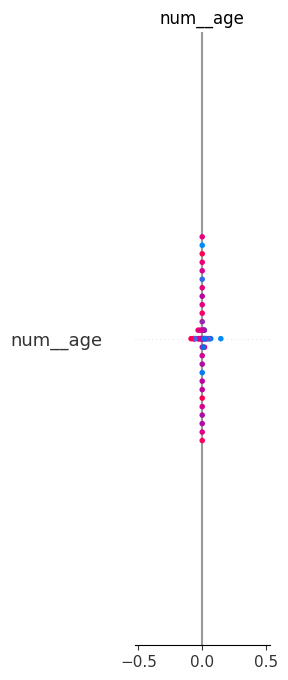

In [23]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names)

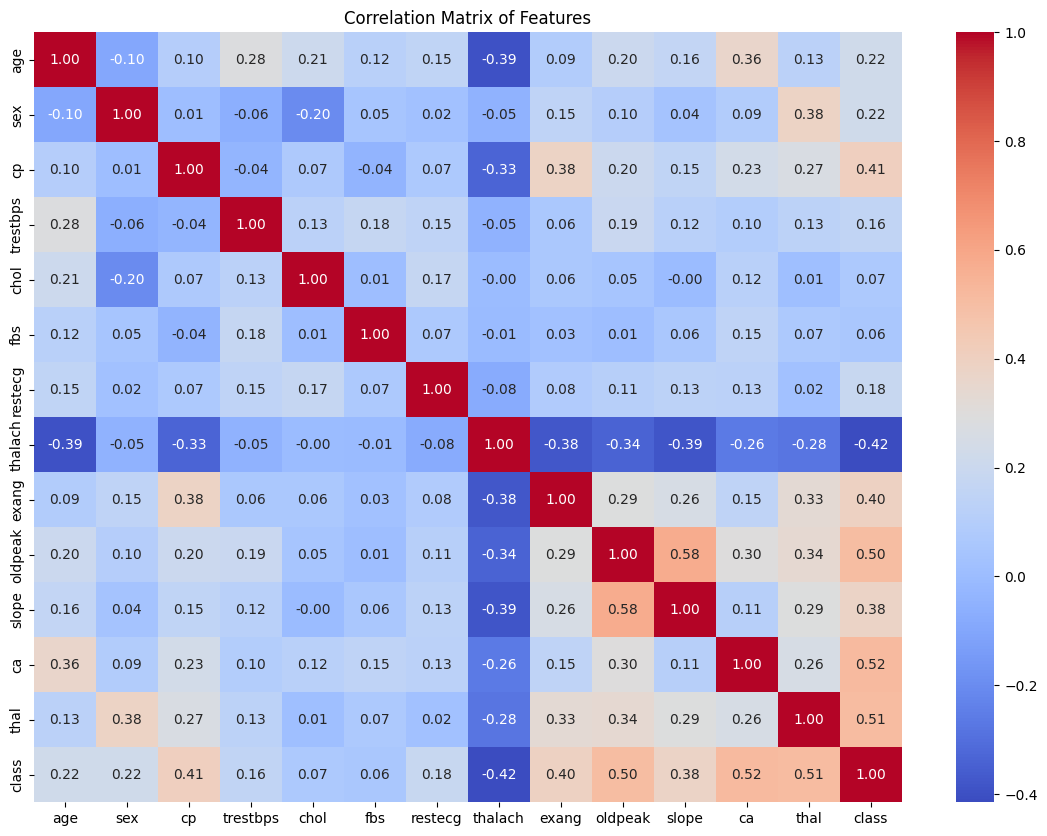

In [27]:
# Correlation Matrix Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

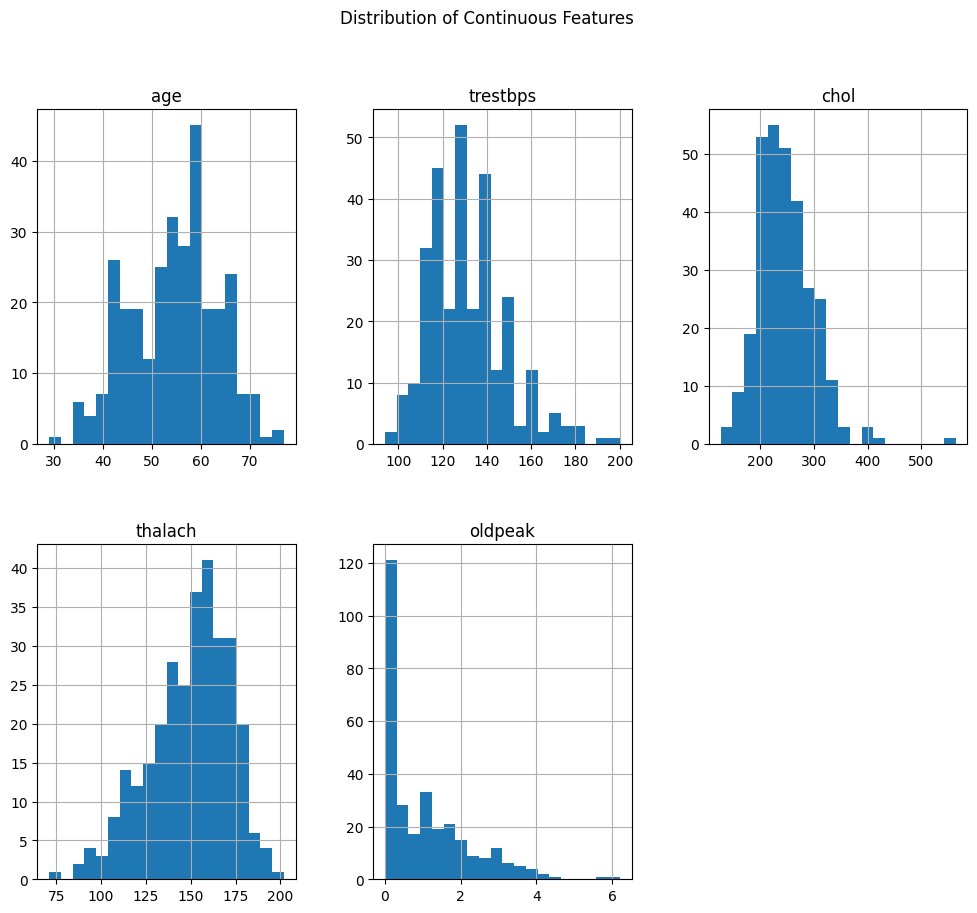

In [25]:
# Distribution of Continuous Features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
data[continuous_features].hist(figsize=(12, 10), bins=20, layout=(2, 3))
plt.suptitle("Distribution of Continuous Features")
plt.show()

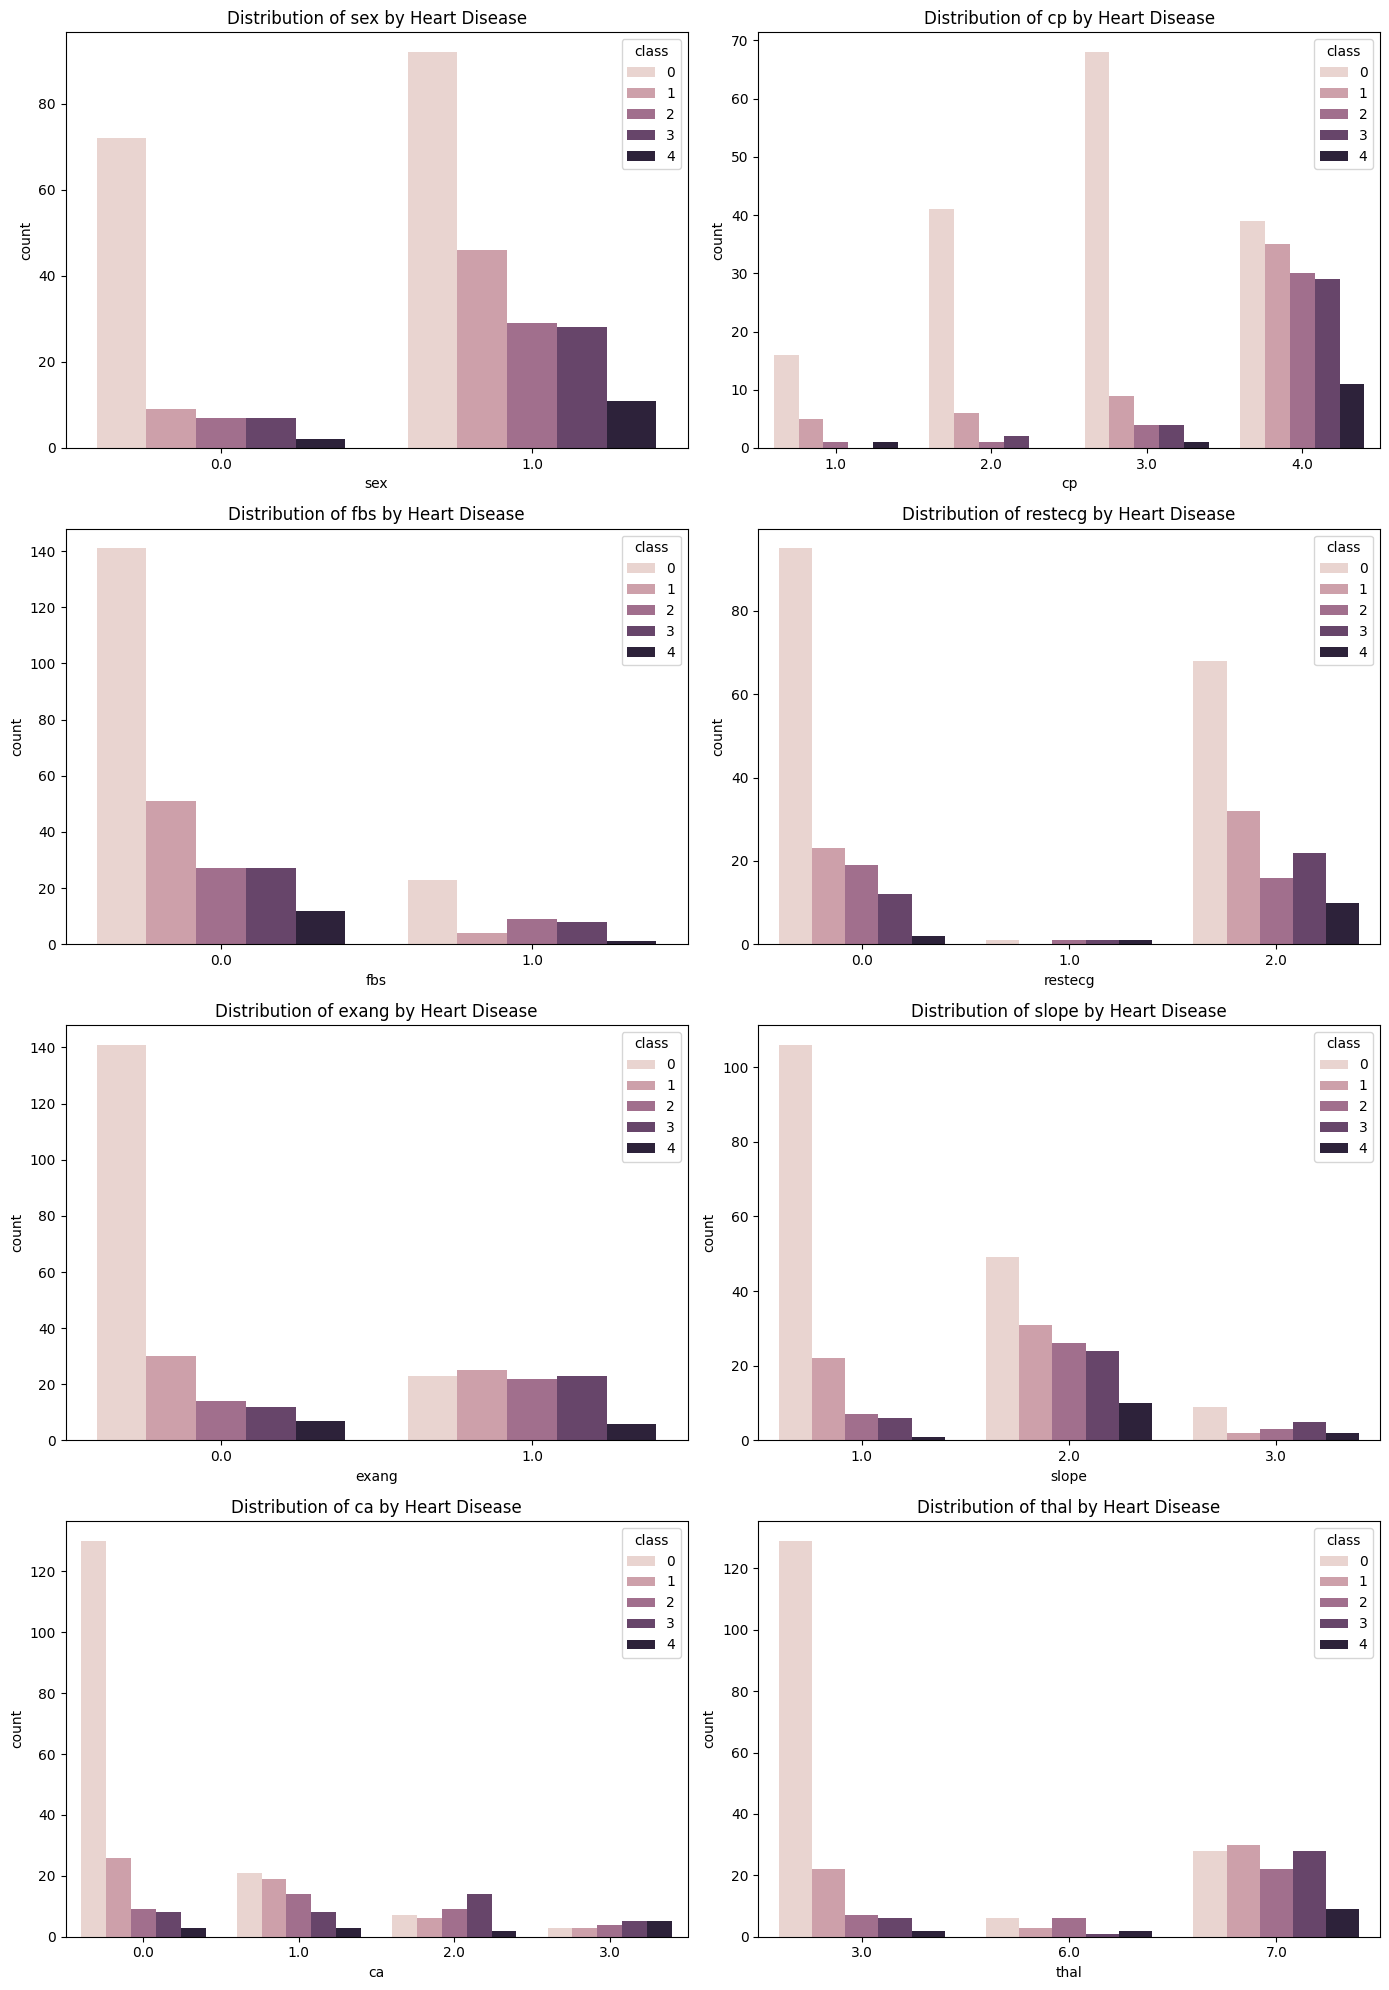

In [28]:
# Count Plots for Categorical Features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='class', data=data, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {feature} by Heart Disease')
plt.tight_layout()
plt.show()


### Model Evaluation ###


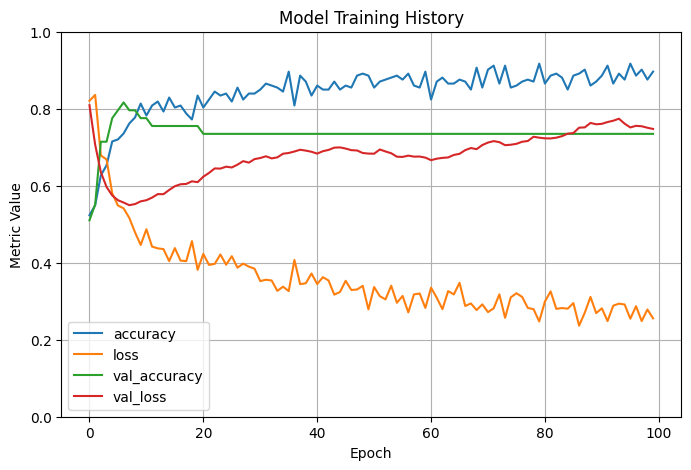

In [29]:
print("\n### Model Evaluation ###")
# Training History Plot
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Model Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


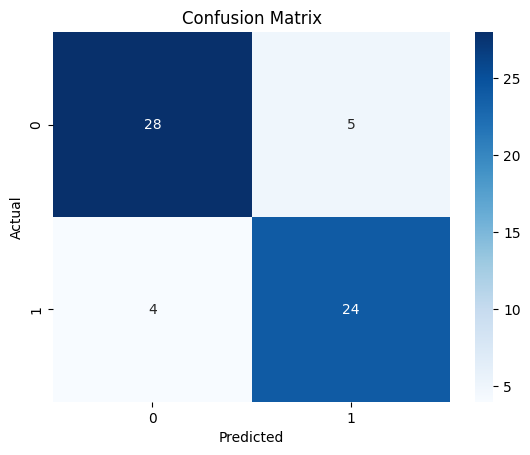

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = (enhanced_model.predict(X_test_processed) > 0.5).astype("int32")
cm = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


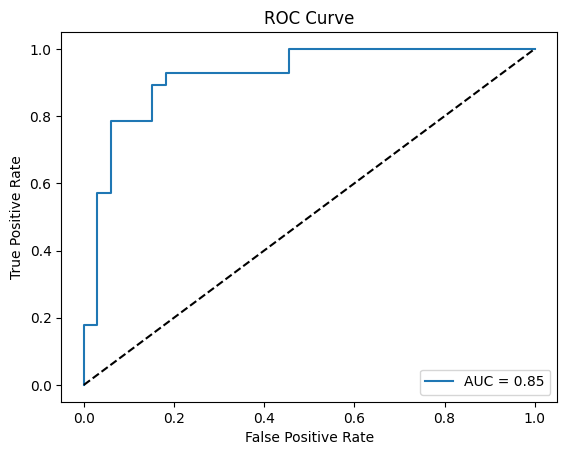

In [34]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_binary, enhanced_model.predict(X_test_processed))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_binary, y_pred):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [36]:
import ipywidgets as widgets
from ipywidgets import interact

def predict_heart_disease(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
    # Create a DataFrame from the inputs
    input_data = pd.DataFrame({
        'age': [age], 'sex': [sex], 'cp': [cp], 'trestbps': [trestbps], 'chol': [chol],
        'fbs': [fbs], 'restecg': [restecg], 'thalach': [thalach], 'exang': [exang],
        'oldpeak': [oldpeak], 'slope': [slope], 'ca': [ca], 'thal': [thal]
    })

    # Preprocess the input data
    input_processed = preprocessor.transform(input_data)

    # Make a prediction
    prediction_proba = enhanced_model.predict(input_processed)[0][0]
    prediction = (prediction_proba > 0.5).astype(int)

    # Display the result
    if prediction == 1:
        print(f"Prediction: Heart Disease (Probability: {prediction_proba:.2f})")
    else:
        print(f"Prediction: No Heart Disease (Probability: {1 - prediction_proba:.2f})")

# Create widgets for each feature
age_widget = widgets.IntSlider(min=20, max=80, step=1, value=50, description='Age:')
sex_widget = widgets.Dropdown(options=[('Male', 1), ('Female', 0)], value=1, description='Sex:')
cp_widget = widgets.Dropdown(options=[('Typical Angina', 1), ('Atypical Angina', 2), ('Non-anginal Pain', 3), ('Asymptomatic', 4)], value=1, description='Chest Pain:')
trestbps_widget = widgets.IntSlider(min=90, max=200, step=1, value=120, description='Resting BP:')
chol_widget = widgets.IntSlider(min=100, max=600, step=1, value=200, description='Cholesterol:')
fbs_widget = widgets.Dropdown(options=[('True', 1), ('False', 0)], value=0, description='Fasting BS > 120:')
restecg_widget = widgets.Dropdown(options=[('Normal', 0), ('ST-T wave abnorm', 1), ('LV hypertrophy', 2)], value=0, description='Resting ECG:')
thalach_widget = widgets.IntSlider(min=70, max=210, step=1, value=150, description='Max Heart Rate:')
exang_widget = widgets.Dropdown(options=[('Yes', 1), ('No', 0)], value=0, description='Exercise Angina:')
oldpeak_widget = widgets.FloatSlider(min=0, max=7, step=0.1, value=1, description='Oldpeak:')
slope_widget = widgets.Dropdown(options=[('Upsloping', 1), ('Flat', 2), ('Downsloping', 3)], value=1, description='Slope:')
ca_widget = widgets.Dropdown(options=[(0, 0), (1, 1), (2, 2), (3, 3)], value=0, description='Major Vessels:')
thal_widget = widgets.Dropdown(options=[('Normal', 3), ('Fixed Defect', 6), ('Reversable Defect', 7)], value=3, description='Thal:')

# Use interact to create the UI
interact(predict_heart_disease, age=age_widget, sex=sex_widget, cp=cp_widget, trestbps=trestbps_widget,
         chol=chol_widget, fbs=fbs_widget, restecg=restecg_widget, thalach=thalach_widget,
         exang=exang_widget, oldpeak=oldpeak_widget, slope=slope_widget, ca=ca_widget, thal=thal_widget);

interactive(children=(IntSlider(value=50, description='Age:', max=80, min=20), Dropdown(description='Sex:', op…